In [1]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchmetrics

from facenet_pytorch import InceptionResnetV1

import numpy as np

from recognition.data import DataModule, DataSet
from recognition.model import LitModel


import wandb

from PIL import Image

import matplotlib.pyplot as plt

from pathlib import Path
import os
import shutil

import json

f:\wisesight\celebrity-face-recognition\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## visualize image

In [10]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

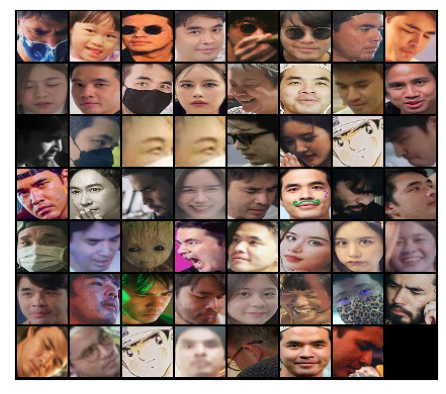

In [63]:
path_train = Path('rawdata/celebrity-face-recognition/dataset/train/')

example_id = '1387675'

image_list = []
files = (path_train / example_id).glob('*')
for path_image in files:
    img = read_image(str(path_image))
    img = torchvision.transforms.functional.resize(img, (50, 50))
    image_list.append(img)

grid = make_grid(image_list)
show(grid)

In [16]:
facenet_model = InceptionResnetV1(pretrained='vggface2') # pretrained model (https://github.com/timesler/facenet-pytorch)
facenet_model.eval()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [54]:
def remove_stranger(model, imgs, threshold=0.5):
    model.eval()
    embedded_feature = model(imgs)
    embedded_mean_feature = embedded_feature.mean(dim=0)
    idx = []
    cos = nn.CosineSimilarity(dim=0)
    for i, ef in enumerate(embedded_feature):
        sim = cos(embedded_mean_feature, ef)
        if sim >= threshold:
            idx.append(i)
    return idx

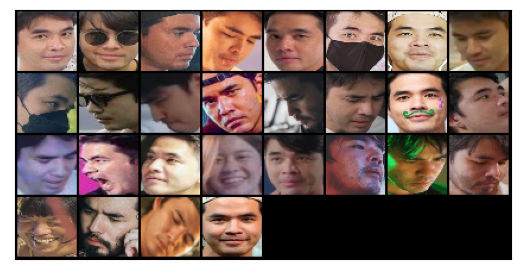

In [64]:
image_list = []
for path_image in (path_train / example_id).glob('*'):
    img = read_image(str(path_image))
    img = torchvision.transforms.functional.resize(img, (160, 160))
    img = img/255.0 
    image_list.append(img)

imgs = torch.stack(image_list, dim=0)

idx = remove_stranger(facenet_model, imgs, threshold=0.5)

image_list = []
files = (path_train / example_id).glob('*')
for i, path_image in enumerate(files):
    if i in idx:
        img = read_image(str(path_image))
        img = torchvision.transforms.functional.resize(img, (50, 50))
        image_list.append(img)

grid = make_grid(image_list)
show(grid)

## create new training set 

In [112]:
def create_new_data(model, path, threshold=0.5):

    cos = nn.CosineSimilarity(dim=0)
    model.eval() 

    new_path = path.parent / (str(path.stem) + '_new')
    folders = list(path.glob('*'))

    for folder in folders:
        new_folder = new_path / folder.stem
        new_folder.mkdir(parents=True, exist_ok=True)
        files = list(folder.glob('*'))
        image_list = []
        for file in files:
            img = read_image(str(file))
            img = torchvision.transforms.functional.resize(img, (160, 160))
            img = img/255.0 
            image_list.append(img)

        imgs = torch.stack(image_list, dim=0)

        embedded_feature = model(imgs)
        embedded_mean_feature = embedded_feature.mean(dim=0)
        for i, ef in enumerate(embedded_feature):
            sim = cos(embedded_mean_feature, ef)
            if sim >= threshold:
                shutil.copy(files[i], new_folder / files[i].name)
                
create_new_data(facenet_model, Path('rawdata/celebrity-face-recognition/dataset/train/'))

## Pytorch lightning module
pretrained facenet model from "vggface2" dataset

In [2]:
LitModel??

Init signature: LitModel(mapping_dir: str, lr: float = 0.0001)
Docstring:      Hooks to be used in LightningModule.
Source:        
class LitModel(pl.LightningModule):
    def __init__(self, mapping_dir: str, lr: float = 1e-4):
        super().__init__()
        with open(mapping_dir) as file:
            self.mapping_account2name = json.loads(file.read())
        self.mapping_class2account = {i: k for i, (k, v) in enumerate(self.mapping_account2name.items())} 
        self.mapping_account2class = {v: k for k, v in self.mapping_class2account.items()}

        self.n_classes = len(self.mapping_account2class)

        self.backbone = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=self.n_classes) 
        self.save_hyperparameters()

        self.loss = nn.CrossEntropyLoss()

        self.lr = lr


        self.init_metrics()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x): # [B, C, H, W]
  

In [3]:
litmodel = LitModel('rawdata/celebrity-face-recognition/accounts.json', lr=1e-4)

## Datamodule

In [4]:
DataModule??

Init signature:
DataModule(
    data_dir: str,
    mapping,
    batch_size: int = 32,
    remove_stranger: bool = False,
)
Docstring:     
A DataModule standardizes the training, val, test splits, data preparation and transforms. The main
advantage is consistent data splits, data preparation and transforms across models.

Example::

    class MyDataModule(LightningDataModule):
        def __init__(self):
            super().__init__()
        def prepare_data(self):
            # download, split, etc...
            # only called on 1 GPU/TPU in distributed
        def setup(self, stage):
            # make assignments here (val/train/test split)
            # called on every process in DDP
        def train_dataloader(self):
            train_split = Dataset(...)
            return DataLoader(train_split)
        def val_dataloader(self):
            val_split = Dataset(...)
            return DataLoader(val_split)
        def test_dataloader(self):
            test_split = Dataset(...

In [6]:
datamodule = DataModule(batch_size=128, data_dir='rawdata/celebrity-face-recognition/dataset/', mapping=litmodel.mapping_account2class, remove_stranger=True)

### wandb.ai for experimental tracking

In [3]:
run = wandb.init(project='celeb-face')

wandb_logger = pl.loggers.WandbLogger(project='celeb-face', log_model='all')
wandb_logger.watch(litmodel, log='gradients')

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min')
early_stopping_callback = pl.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stopping_callback]
    )

trainer.fit(model=litmodel, datamodule=datamodule)

trainer.test(model=litmodel, datamodule=datamodule)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: phum19011. Use `wandb login --relogin` to force relogin


f:\wisesight\celebrity-face-recognition\venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                | Params
---------------------------------------------------------
0  | backbone        | InceptionResnetV1   | 23.8 M
1  | loss            | CrossEntropyLoss    | 0     
2  | train_acc       | MulticlassAccuracy  | 0     
3  | val_acc         | MulticlassAccuracy  | 0     
4  | test_acc        | MulticlassAccuracy  | 0     
5  | train_precision | MulticlassPrecision |

Sanity Checking: 0it [00:00, ?it/s]

f:\wisesight\celebrity-face-recognition\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


f:\wisesight\celebrity-face-recognition\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 33: 100%|██████████| 157/157 [01:15<00:00,  2.08it/s, loss=0.478, v_num=aj0m]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
f:\wisesight\celebrity-face-recognition\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 21/21 [00:36<00:00,  1.73s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.6124004125595093
   test_f1score_epoch       0.6024988293647766
        test_loss            2.298933506011963
  test_precision_epoch      0.6330709457397461
    test_recall_epoch       0.6124004125595093
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
test_acc_epoch,▁
test_acc_step,▆▇▆█▇██▇▇▇▆▇▇▆▇█▇▇▆▇▁
test_f1score_epoch,▁
test_f1score_step,▇▇▆█▇██▇▇▇▆▇▇▆▇█▇█▇▇▁
test_loss,▁
test_precision_epoch,▁
test_precision_step,▇▆▆▇▇█▇█▇▇▇▇▆▇▇▇▆█▇█▁
test_recall_epoch,▁
test_recall_step,▆▇▆█▇██▇▇▇▆▇▇▆▇█▇▇▆▇▁
train_acc_epoch,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇███████████████████


### saving artifact from wandb to local

In [4]:
run = wandb.init()
artifact = run.use_artifact('phum19011/celeb-face/model-1i41aj0m:v11', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model-1i41aj0m:v11, 272.50MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


In [5]:
litmodel = LitModel.load_from_checkpoint(Path(artifact_dir) / 'model.ckpt')
litmodel.eval()

LitModel(
  (backbone): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, tr